# Analyzing Top Highest Grossing Hollywood Movies


#814004342
COMP 3610 - BIG DATA ANALYTICS

This analysis focuses on the top highest grossing movies to determine their characteristics with the column World Sales (in $) being the success indicator of the movie. It represents the movie's earnings.

In [1148]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
from ast import literal_eval

#reading in csv file
movies = pd.read_csv("top_hollywood_grossing_movies.csv")

In [1149]:
#previewing first 5 rows of dataframe
movies.head()

,Unnamed: 0,Title,Movie Info,Distributor,Release Date,Domestic Sales (in $),International Sales (in $),World Sales (in $),Genre,Movie Runtime,License
0,0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...",Walt Disney Studios Motion Pictures,"December 16, 2015",936662225,1132859475,2069521700,"['Action', 'Adventure', 'Sci-Fi']",2 hr 18 min,PG-13
1,1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,Walt Disney Studios Motion Pictures,"April 24, 2019",858373000,1939128328,2797501328,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",3 hr 1 min,PG-13
2,2,Avatar (2009),A paraplegic Marine dispatched to the moon Pan...,Twentieth Century Fox,"December 16, 2009",760507625,2086738578,2847246203,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",2 hr 42 min,PG-13
3,3,Black Panther (2018),"T'Challa, heir to the hidden but advanced king...",Walt Disney Studios Motion Pictures,NaN,700426566,647171407,1347597973,"['Action', 'Adventure', 'Sci-Fi']",2 hr 14 min,NaN
4,4,Avengers: Infinity War (2018),The Avengers and their allies must be willing ...,Walt Disney Studios Motion Pictures,NaN,678815482,1369544272,2048359754,"['Action', 'Adventure', 'Sci-Fi']",2 hr 29 min,NaN


In [1150]:
#getting information on dataframe and finding out null values in each column using df.info() method
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  900 non-null    int64 
 1   Title                       900 non-null    object
 2   Movie Info                  900 non-null    object
 3   Distributor                 900 non-null    object
 4   Release Date                698 non-null    object
 5   Domestic Sales (in $)       900 non-null    int64 
 6   International Sales (in $)  900 non-null    int64 
 7   World Sales (in $)          900 non-null    int64 
 8   Genre                       900 non-null    object
 9   Movie Runtime               900 non-null    object
 10  License                     729 non-null    object
dtypes: int64(4), object(7)
memory usage: 77.5+ KB


As we can see there are null values in the Release Date and License columns which would need to be addressed. The Genre column would need to be one hot encoded and the Movie Runtime column would be converted to minutes.

## Data Cleaning

In [1151]:
#helper function to find percent of missing data from each column
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [1152]:
produce_missing_report(movies)

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.000000
Title,Title,0.000000
Movie Info,Movie Info,0.000000
Distributor,Distributor,0.000000
Release Date,Release Date,22.444444
Domestic Sales (in $),Domestic Sales (in $),0.000000
International Sales (in $),International Sales (in $),0.000000
World Sales (in $),World Sales (in $),0.000000
Genre,Genre,0.000000
Movie Runtime,Movie Runtime,0.000000


The format for the 'Release Date' column is: month,day,year. Important to note that the year of release is contained within brackets in the 'Title' column as well so we can use that year for the null values in the 'Release Date' column.

In [1153]:
movies['License'].value_counts()

PG-13    357
R        189
PG       169
G         14
Name: License, dtype: int64

<AxesSubplot: >

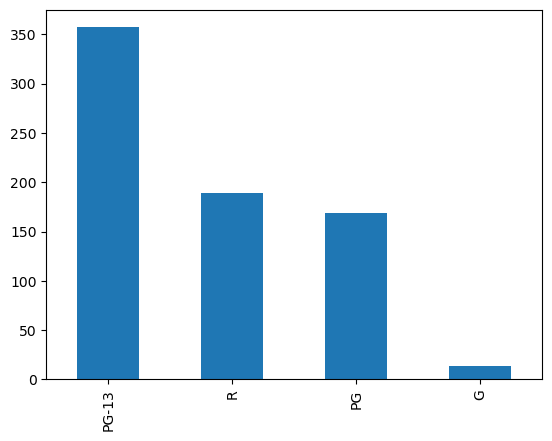

In [1154]:
movies['License'].value_counts().plot.bar()

Based on the bar chart above, we see that PG-13 represents the most frequent category followed by R and PG, with rating G being the least frequent rating. There are 171 missing values for the License column and the mode or most frequent category would be imputed for the missing values.

In [1155]:
movies['License'] = movies['License'].fillna('PG-13')
movies['License'].value_counts()


PG-13    528
R        189
PG       169
G         14
Name: License, dtype: int64

Given that the year of the movie's release is contained in the Title column, the year can be extracted and used to create a new column called Release Year for each movie.


In [1156]:
movies['Release Year'] = movies['Title'].str.extract('.*\((.*)\).*')
movies['Release Year']

0      2015
1      2019
2      2009
3      2018
4      2018
       ... 
895    2007
896    2007
897    2006
898    2016
899    2017
Name: Release Year, Length: 900, dtype: object

Next, the Movie Runtime column would be converted to minutes in a new column called Movie Runtime(mins).

In [1157]:
movies['Movie Runtime'] = movies['Movie Runtime'].str.replace('hr',',').str.replace('min','').str.replace(' ','')
movies[['Hour','Minutes']] = movies['Movie Runtime'].str.split(",",expand=True)
movies['Hour'] = movies['Hour'].astype(int)
movies['Minutes'] = movies['Minutes'].replace('',np.nan,regex = True)
movies['Minutes'] = movies['Minutes'].astype(float)
movies['Minutes'] = movies['Minutes'].fillna(0)
movies['Movie Runtime(mins)'] = ((movies['Hour'] * 60) + movies['Minutes'])
movies.drop(['Movie Runtime','Minutes','Release Date','Unnamed: 0'],axis=1,inplace=True)


In [1158]:

#making a copy of the genre column for analysis later
movies['Genres'] = movies['Genre']


One-hot encoding of genre column to split each genre into its own column and assign a 1 for each movie of that genre and a 0 otherwise.

In [1159]:

movies['Genre'] = movies['Genre'].str.replace("'",'').str.replace("'",'').str.replace("-",' ').str.replace(" ",'').str.replace("[",'').str.replace("]",'')

m1 = movies['Genre'].str.get_dummies(sep = ',')
m1.shape


C:\Users\justi\AppData\Local\Temp\ipykernel_10552\3783602119.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['Genre'] = movies['Genre'].str.replace("'",'').str.replace("'",'').str.replace("-",' ').str.replace(" ",'').str.replace("[",'').str.replace("]",'')


(900, 21)

The genre column was one hot encoded and stored in a new dataframe called m1. Based on the shape returned, we see that there are 21 total genres.

In [1160]:
movies = pd.concat([movies,m1],axis=1)
movies.head()

,Title,Movie Info,Distributor,Domestic Sales (in $),International Sales (in $),World Sales (in $),Genre,License,Release Year,Hour,...,Horror,Music,Musical,Mystery,Romance,SciFi,Sport,Thriller,War,Western
0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...",Walt Disney Studios Motion Pictures,936662225,1132859475,2069521700,"Action,Adventure,SciFi",PG-13,2015,2,...,0,0,0,0,0,1,0,0,0,0
1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,Walt Disney Studios Motion Pictures,858373000,1939128328,2797501328,"Action,Adventure,Drama,SciFi",PG-13,2019,3,...,0,0,0,0,0,1,0,0,0,0
2,Avatar (2009),A paraplegic Marine dispatched to the moon Pan...,Twentieth Century Fox,760507625,2086738578,2847246203,"Action,Adventure,Fantasy,SciFi",PG-13,2009,2,...,0,0,0,0,0,1,0,0,0,0
3,Black Panther (2018),"T'Challa, heir to the hidden but advanced king...",Walt Disney Studios Motion Pictures,700426566,647171407,1347597973,"Action,Adventure,SciFi",PG-13,2018,2,...,0,0,0,0,0,1,0,0,0,0
4,Avengers: Infinity War (2018),The Avengers and their allies must be willing ...,Walt Disney Studios Motion Pictures,678815482,1369544272,2048359754,"Action,Adventure,SciFi",PG-13,2018,2,...,0,0,0,0,0,1,0,0,0,0


In [1161]:
#dropping columns before final analysis
movies.drop(['Movie Info','Genre'],axis=1,inplace=True)

## Outlier Analysis

In [1162]:
#outlier analysis on World Sales (in $)
movies.describe()['World Sales (in $)']
#movies['World Sales (in $)'].idxmax()

count    9.000000e+02
mean     4.017626e+08
std      3.092720e+08
min      8.260470e+07
25%      2.033883e+08
50%      3.070346e+08
75%      4.827288e+08
max      2.847246e+09
Name: World Sales (in $), dtype: float64

<AxesSubplot: >

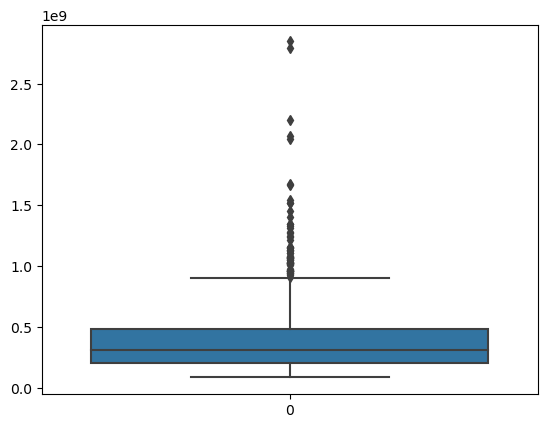

In [1163]:
sns.boxplot(movies['World Sales (in $)'])

In [1164]:
#finding q1 and q3
q1 = movies['World Sales (in $)'].quantile(0.25)
q3 = movies['World Sales (in $)'].quantile(0.75)
print(q1,q3)

203388302.25 482728831.75


In [1165]:
#finding iqr
iqr = q3-q1
print(iqr)

279340529.5


In [1166]:
#finding lower and upper bounds
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
print(lower_bound,upper_bound)

-215622492.0 901739626.0


In [1167]:
#movies[(movies['World Sales (in $)']<lower_bound)|(movies['World Sales (in $)']>upper_bound)]
movies_upper = movies[movies['World Sales (in $)']>upper_bound]
movies_upper.head()

,Title,Distributor,Domestic Sales (in $),International Sales (in $),World Sales (in $),License,Release Year,Hour,Movie Runtime(mins),Genres,...,Horror,Music,Musical,Mystery,Romance,SciFi,Sport,Thriller,War,Western
0,Star Wars: Episode VII - The Force Awakens (2015),Walt Disney Studios Motion Pictures,936662225,1132859475,2069521700,PG-13,2015,2,138.0,"['Action', 'Adventure', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
1,Avengers: Endgame (2019),Walt Disney Studios Motion Pictures,858373000,1939128328,2797501328,PG-13,2019,3,181.0,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
2,Avatar (2009),Twentieth Century Fox,760507625,2086738578,2847246203,PG-13,2009,2,162.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
3,Black Panther (2018),Walt Disney Studios Motion Pictures,700426566,647171407,1347597973,PG-13,2018,2,134.0,"['Action', 'Adventure', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
4,Avengers: Infinity War (2018),Walt Disney Studios Motion Pictures,678815482,1369544272,2048359754,PG-13,2018,2,149.0,"['Action', 'Adventure', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0


In [1168]:
movies_upper.shape

(62, 31)

The above dataframe represents the movies that were considered outliers in terms of their great success as shown by their World Sales (in $).

In [1169]:
movies_no_upper = movies[movies['World Sales (in $)']<upper_bound]
movies_no_upper.head()

,Title,Distributor,Domestic Sales (in $),International Sales (in $),World Sales (in $),License,Release Year,Hour,Movie Runtime(mins),Genres,...,Horror,Music,Musical,Mystery,Romance,SciFi,Sport,Thriller,War,Western
19,Star Wars: Episode IV - A New Hope (1977),Twentieth Century Fox,460998507,195751992,775398007,PG,1977,2,121.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
23,E.T. the Extra-Terrestrial (1982),Universal Pictures,435110554,304203888,792910554,PG,1982,1,115.0,"['Adventure', 'Family', 'Sci-Fi']",...,0,0,0,0,0,1,0,0,0,0
26,The Hunger Games: Catching Fire (2013),Lionsgate,424668047,440343699,865011746,PG-13,2013,2,146.0,"['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Th...",...,0,0,0,0,0,1,0,1,0,0
31,Wonder Woman (2017),Warner Bros.,412815408,410009114,822824522,PG-13,2017,2,141.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi', '...",...,0,0,0,0,0,1,0,0,1,0
34,The Hunger Games (2012),Lionsgate,408010692,286384032,694394724,PG-13,2012,2,142.0,"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",...,0,0,0,0,0,1,0,1,0,0


Analyzing the movies without upper outliers

<AxesSubplot: title={'center': 'Movie Distributors'}, xlabel='Count'>

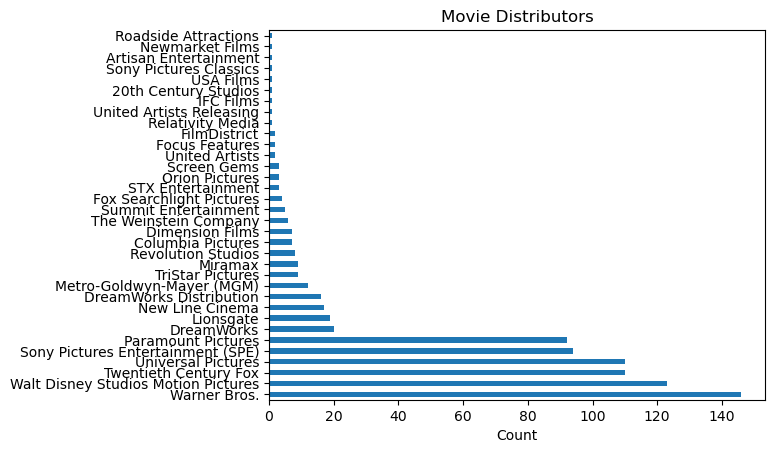

In [1170]:
movies_no_upper['Distributor'].value_counts().plot(kind='barh',title="Movie Distributors",xlabel="Count")


As we can see the top 5 Movie Distributors are: Warner Bros, Walt Disney Studios Motion Pictures, Twentieth Century Fox, Universal Pictures and Sony Pictures Entertainment.

<AxesSubplot: title={'center': 'Movie Ratings'}, xlabel='Count'>

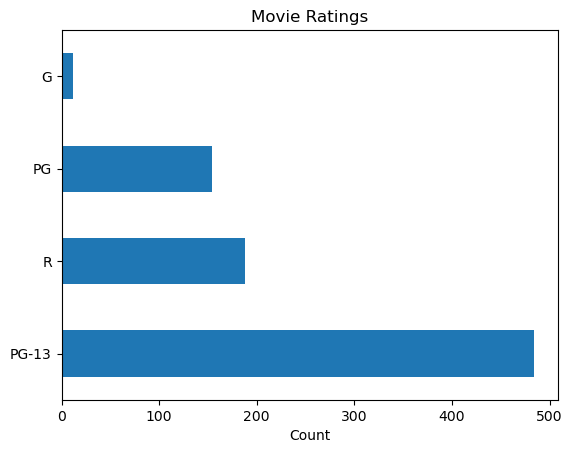

In [1171]:
movies_no_upper['License'].value_counts().plot(kind='barh',title="Movie Ratings",xlabel="Count")

Based on the chart above the majority of highest grossing movies were rated PG-13.

<AxesSubplot: title={'center': 'Movie Hours'}, xlabel='Count', ylabel='Hour'>

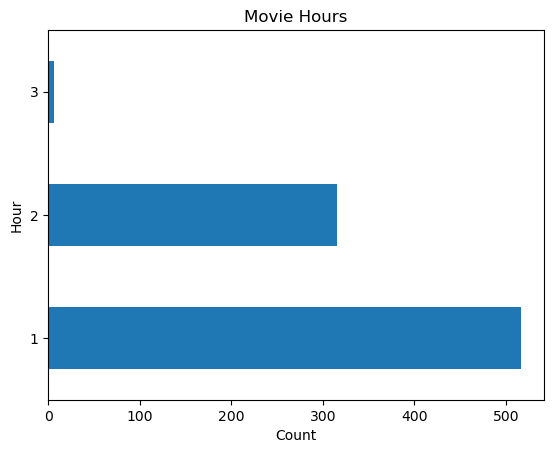

In [1172]:
movies_no_upper['Hour'].value_counts().plot(kind='barh',title="Movie Hours",xlabel="Count",ylabel="Hour")

This shows that most of the highest grossing movies were at least one hour long.

<AxesSubplot: title={'center': 'Movie Genres'}, xlabel='Count', ylabel='Genres'>

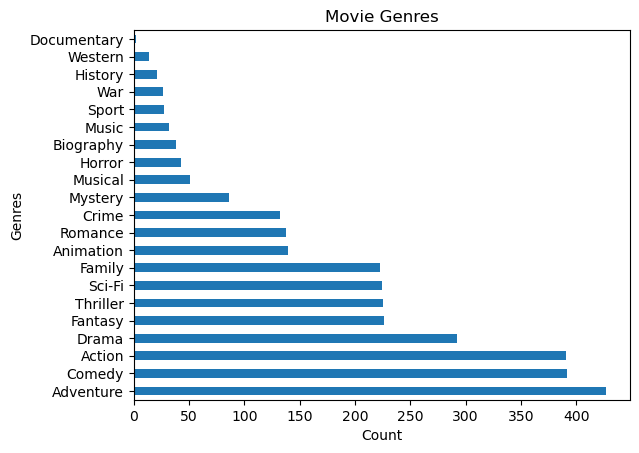

In [1173]:
movies['Genres'] = movies['Genres'].apply(literal_eval) #convert to list type
movies['Genres'].explode().value_counts().plot(kind='barh',title="Movie Genres",xlabel="Count",ylabel="Genres")

The plot above shows the three most frequent genres of highest grossing movies were: Adventure, Comedy and Action.

## Final Recommendations

Based on the analysis conducted above on some of the characteristics of highest grossing movies are that they were mostly rated PG-13. One reason for this can be due to the PG-13 rating allowing for a wider audience with less audience restriction due to age. Most of these movies were produced by Warner Bros, Walt Disney Studios Motion Pictures, Twentieth Century Fox, Universal Pictures and Sony Pictures Entertainment. They mostly had a runtime of between 1 and 2 hours and consisted of the Adventure, Comedy and Action Genres.